## 고양이 수염 붙이기
-----

### 반복사용되는 모듈 추가

In [101]:
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import dlib

### 이미지 불러오기

[[[ 78  87  60]
  [ 78  87  60]
  [ 78  87  60]
  ...
  [ 72  83  57]
  [ 72  83  57]
  [ 72  83  57]]

 [[ 78  87  60]
  [ 78  87  60]
  [ 78  87  60]
  ...
  [ 72  83  57]
  [ 72  83  57]
  [ 72  83  57]]

 [[ 78  87  60]
  [ 78  87  60]
  [ 78  87  60]
  ...
  [ 72  83  57]
  [ 72  83  57]
  [ 72  83  57]]

 ...

 [[255 237 239]
  [255 237 239]
  [254 238 239]
  ...
  [115 126 134]
  [115 125 135]
  [115 126 134]]

 [[252 233 236]
  [254 238 239]
  [254 240 241]
  ...
  [112 124 134]
  [112 124 136]
  [112 124 134]]

 [[250 233 236]
  [252 238 240]
  [254 240 241]
  ...
  [112 124 136]
  [112 124 136]
  [112 124 136]]]


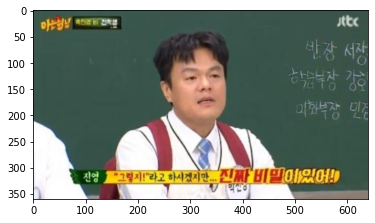

(360, 640, 3)


In [398]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/jyp1.jpg'
img_bgr = cv2.imread(my_image_path,-1)    #- OpenCV로 이미지를 읽어서
print(img_bgr)
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show()
print(img_rgb.shape)

### 이미지에 rectangle 씌우기 

In [375]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(270, 92) (378, 199)]]


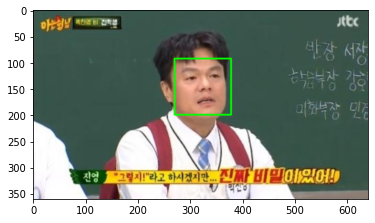

In [399]:
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show,(l,t), (r,b), (0, 255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### face landmark 모델 추가

In [136]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

68


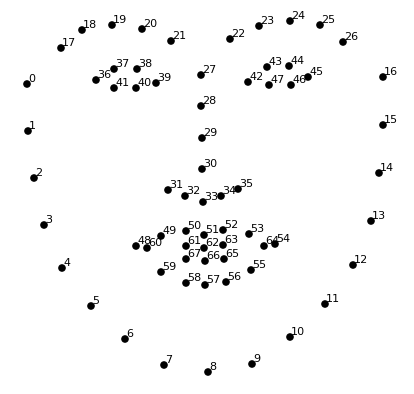

### 2, 36, 30, 48번을 이용하자

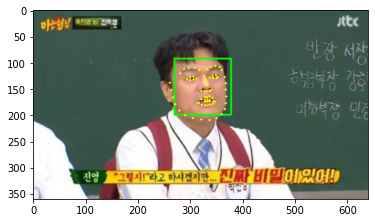

In [400]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [425]:
# 고양이 수염용 랜드마크 좌표: 2,36,48,30 
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[2]) # nose center index : 2
    print(landmark[36]) # nose center index : 36
    print(landmark[48]) # nose center index : 48
    print(landmark[30]) # nose center index : 30
    # landmark 33 좌표
    x = landmark[33][0]
    y = landmark[33][1]
    # 얼굴 인식 영역 가로 세로 길이
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print(f'(x,y): {x, y}')
    print(f'(w,h): {w, h}')
    print(2*(landmark[48][1]-y))
    
    

(267, 166)
(294, 131)
(314, 177)
(332, 142)
(x,y): (332, 155)
(w,h): (109, 108)
44


In [428]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers1.png'
img_sticker = cv2.imread(sticker_path)
resize_x, resize_y = 2*(x - w//2), 2*(landmark[48][1]-y)
img_sticker = cv2.resize(img_sticker, (resize_x,resize_y)) # 얼굴 인식 영역에 맞춰서 스티커크기 조정
print(img_sticker.shape)

(44, 556, 3)


In [420]:
refind_x = x + img_sticker.shape[0]
refind_y = y + (img_sticker.shape[1])//2
print(refind_x, refind_y)

376 433


In [422]:
# sticker 영역 설정 
print(img_show.shape)
sticker_area = img_show[refind_y:refind_y+img_sticker.shape[0], refind_x:refind_x+img_sticker.shape[1]]
sticker_area_rgb = cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB)
plt.imshow(sticker_area_rgb)
plt.show()

# img_show에 스티커 합성
img_show[refind_y:refind_y+img_sticker.shape[0], refind_x:refind_x+img_sticker.shape[1]] = np.where(img_sticker==0, sticker_area, img_sticker).astype(np.uint8)

(360, 640, 3)


error: OpenCV(4.5.1) /tmp/pip-req-build-hj027r8z/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [396]:
#print(img_show.T)
#print(len(img_show.T[0, 0, 0:]))
#print(img_show[x:landmark[14][0], y:landmark[48][1]])

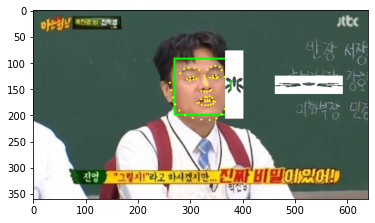

In [397]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()